In [1]:
# sys, file and nav packages:
import datetime as dt

# math packages:
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.distributions.empirical_distribution import ECDF


# charting:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib.dates as mdates
from matplotlib import ticker
import seaborn as sns

# home brew utitilties
import resources.utility_functions as ut
import resources.chart_kwargs as ck
import resources.sr_ut as sut

# images and display
import base64, io, IPython
from PIL import Image as PILImage
from IPython.display import Markdown as md

# set some parameters:
today = dt.datetime.now().date().strftime("%Y-%m-%d")
start_date = '2020-03-01'
end_date ='2021-05-31'
a_fail_rate = .5

unit_label = 'pcs_m'

# name of the output folder:
name_of_project = 'land_use_correlation_method'

# add the folder to the directory tree:
project_directory = ut.make_project_folder('output', name_of_project)

# get your data:
survey_data = pd.read_csv('resources/checked_sdata_eos_2020_21.csv')
river_bassins = ut.json_file_get("resources/river_basins.json")
dfBeaches = pd.read_csv("resources/beaches_with_land_use_rates.csv")
dfCodes = pd.read_csv("resources/codes_with_group_names_2015.csv")
# dfDims = pd.read_csv("resources/dims_data.csv")

# set the index of the beach data to location slug
dfBeaches.set_index('slug', inplace=True)

# set the code index and edit descriptions for display:
dfCodes.set_index('code', inplace=True)

# make a map to the code descriptions
code_description_map = dfCodes.description

# these descriptions need to be shortened for display
dfCodes = sut.shorten_the_value(["G74", "description", "Insulation: includes spray foams"], dfCodes)
dfCodes = sut.shorten_the_value(["G940", "description", "Foamed EVA for crafts and sports"], dfCodes)
dfCodes = sut.shorten_the_value(["G96", "description", "Sanitary-pads/tampons, applicators"], dfCodes)
dfCodes = sut.shorten_the_value(["G178", "description", "Metal bottle caps and lids"], dfCodes)
dfCodes = sut.shorten_the_value(["G82", "description", "Expanded foams 2.5cm - 50cm"], dfCodes)
dfCodes = sut.shorten_the_value(["G81", "description", "Expanded foams .5cm - 2.5cm"], dfCodes)
dfCodes = sut.shorten_the_value(["G117", "description", "Expanded foams < 5mm"], dfCodes)
dfCodes = sut.shorten_the_value(["G75", "description", "Plastic/foamed polystyrene 0 - 2.5cm"], dfCodes)
dfCodes = sut.shorten_the_value(["G76", "description", "Plastic/foamed polystyrene 2.5cm - 50cm"], dfCodes)
dfCodes = sut.shorten_the_value(["G24", "description", "Plastic lid rings"], dfCodes)
dfCodes = sut.shorten_the_value(["G33", "description", "Lids for togo drinks plastic"], dfCodes)
dfCodes = sut.shorten_the_value(["G3", "description", "Plastic bags, carier bags"], dfCodes)
dfCodes = sut.shorten_the_value(["G204", "description", "Bricks, pipes not plastic"], dfCodes)

(luseprofile)=
# The land use profile

*The land use profile* is a numerical representation of the type and amplitude of economic activity around the survey location. It is calculated by using the data stored in map layers available at the [_Federal geoportal_](https://www.geo.admin.ch/) and at the [_Swiss federal statistical office_](https://www.bfs.admin.ch/bfs/en/home.html).

Trash is a collection of objects found in the natural environment. The object itself and the context in which it is found are indicators of economic and geographic origin. How the land is used in proximity to the survey location is an important context to consider when evaluating survey results. {cite}`aydin` {cite}`grelaud`

In September 2020 the European Union issued beach-litter baselines and target values. After considering the many factors, including the transparency of the calculation method the EU decided that the median value of survey results would be used to compare surveys. **This has incited interest in communities to better identify and quantify point sources of trash as they attempt to find the most efficient way to meet target values**. Identifying relevant land use patterns and features is an essential element in the process. {cite}`threshholdeu` {cite}`eubaselines` {cite}`vanemmerick`

Here we propose a method to evaluate the results of beach-litter-surveys with respect to the land use profile within 1500m of the survey location. The survey results of the most common objects are tested for association against the measured land use features using Spearmans $\rho$ or *Spearmans ranked correlation*, a non parametric test of association. {cite}`defspearmans` {cite}`spearmansexplained`

## Assessing land use

The land use profile is comprised of the measurable properties that are geo-located and can be extracted from the current versions of *Statistique Suisse de la superficie* and *swissTlmRegio*. {cite}`superficie` {cite}`tlmregio`. 

The following values were calculated within a radius of 1500m of each survey location:

1. \% of surface area attributed to buildings
2. \% of surface area left to woods
3. \% of surface area attributed to outdoor activities
4. \% of surface area attributed to aggriculture
5. length in kilometers of all roads and trails (railways not included)
6. number of river discharge intersections

**Calculating the land use profile**

The _Office fédéral de la statistique_ provides the 'Statistique de superficie', a grid of points 100m x 100m that covers Switzerland. Each point is assigned one of 27 different land use categories defined by  standard classification of 2004. This grid serves as the basis for calculating how the land is used around the survey area. For this study the land use categories were aggregated into seven groups from the twenty seven available categories.

*The aggregated values and the corresponding land use categories*

* buildings: (1, 2, 3, 4, 5, 9)
* transportation:(6, 7, 8)
* recreation: (10)
* agriculture: (11, 12, 13, 14, 15, 16, 18)
* woods: (17, 19, 20, 21, 22)
* water: (23, 24)
* unproductive: (25, 26, 27)

For each location the cumulative sum and the cumulative sum of each group was calculated within the 1500m buffer. The amount allocated to *water* was subtracted from the cumulative sum, the result was used to calculate the percent of land use attributed for each category.

The category *recreation* includes diverse public use applications. Uses range from sports fields to cemeteries, this captures all areas set aside for social activities.

**Calculating street length**

The street length was calculated by intersecting the map layer swissTLM3D_TLM_STRASSE with the 1500m buffer of each survey location. All the streets and pathways were combined into one line (QGIS: dissolve) and the length of that line is the reported value of kilometers of streets.

**Counting riverine inputs**

For locations on lakes, the number of intersecting river/canal discharges was calculated within 1500m of each survey location. The map layer swissTLM3D_TLM_FLIESSGEWAESSER (rivers) was intersected with swissTLM3D_TLM_STEHENDES_GEWAESSER (lakes), (QGIS: "line intersections"),  and the number of intersections per 1500m buffer was counted, (QGIS: "count points in polygon"). The lakes map layer was extended by 100 meters to capture any discharge points or streams that terminated in close proximity to the lake. {cite}`qgis_software` {cite}`tlmregio`

*Map layers used to calculate the land use profile. __Top left:__ all measureable values within 1500m. __Top right:__ streets and river intersections within 1500m. __Bottom right:__ land use points used to calculate \% of total and total.*


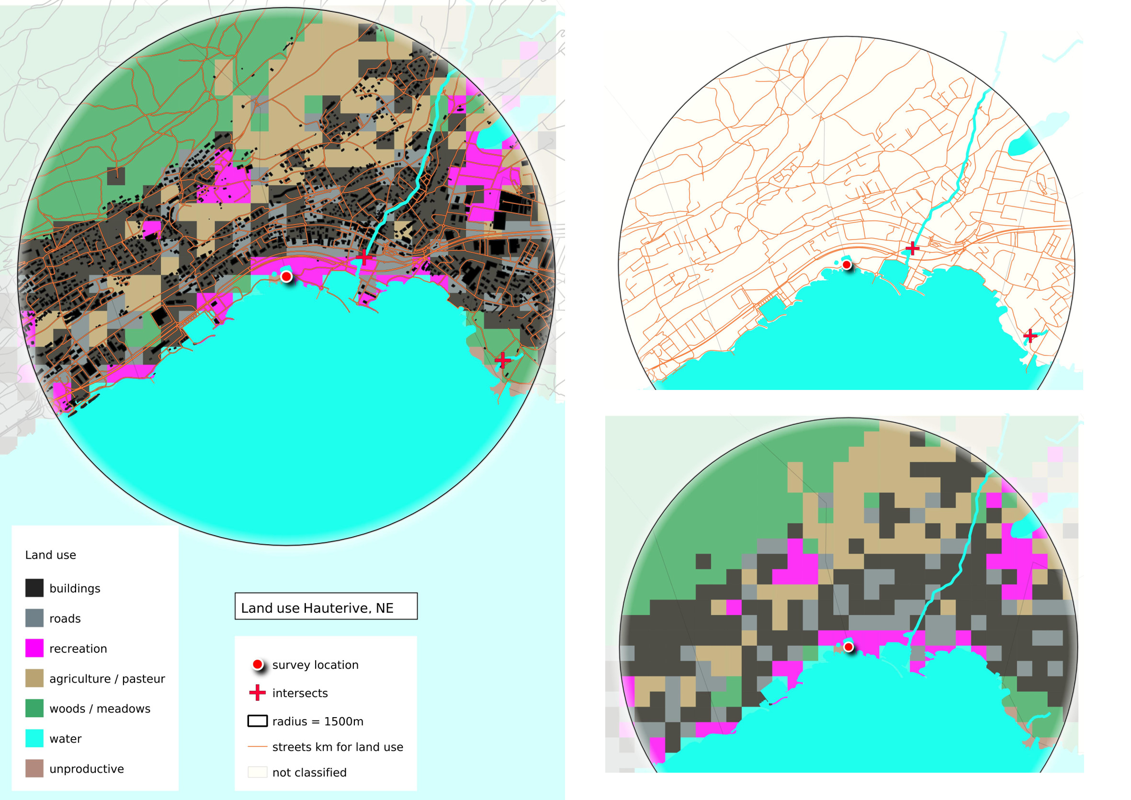

In [2]:
output = io.BytesIO()
a_map=PILImage.open("resources/maps/explain_landuse/land_use_dispaly_20.jpeg")
a_map.thumbnail((1200, 800))
a_map.save(output, format='PNG')
encoded_string = base64.b64encode(output.getvalue()).decode()

html = '<img src="data:image/png;base64,{}"/>'.format(encoded_string)
IPython.display.HTML(html)

_Calculated Land use profile of hauterive-petite-plage, NE._

    *  to builidings: 32.7%
    *  to recreation: 9.9%
    *  to aggriculture: 18.9%
    *  to woods: 24.3%
    *  kilometers of streets 85
    *  river of intersects: 2




*Surveying in a rural location. Kallnach, 26-02-2021*


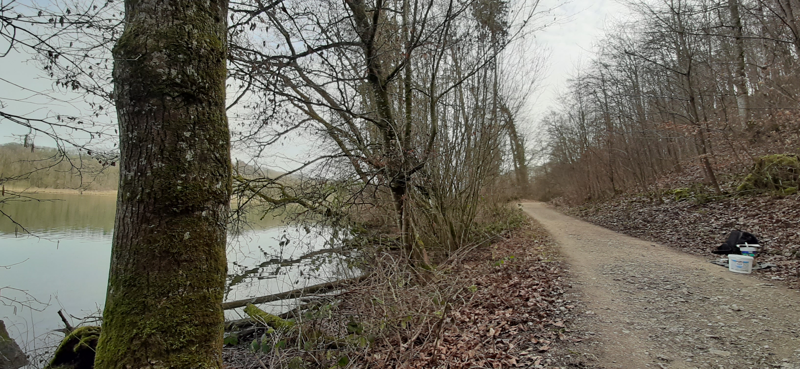

In [3]:
output = io.BytesIO()

this_image = PILImage.open("resources/codegroups/images/tightquarterswholensee.jpg")
this_image.thumbnail((800, 1200))
this_image.save(output, format='PNG')
encoded_string = base64.b64encode(output.getvalue()).decode()

html = '<img src="data:image/png;base64,{}"/>'.format(encoded_string)
IPython.display.HTML(html)

*Surveying in an urban location. Vevey, 28-02-2021*


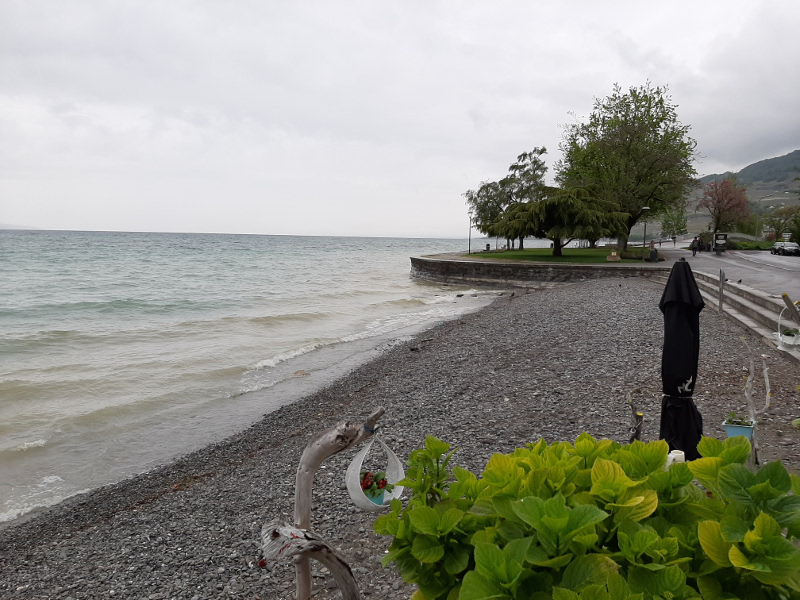

In [4]:
output = io.BytesIO()

this_image = PILImage.open("resources/codegroups/images/urban2_800_600.jpg")
this_image.thumbnail((800, 1200))
this_image.save(output, format='PNG')
encoded_string = base64.b64encode(output.getvalue()).decode()

html = '<img src="data:image/png;base64,{}"/>'.format(encoded_string)
IPython.display.HTML(html)

<!-- <table>
<tr>
<th>Json 1</th>
<th>Markdown</th>
</tr>
<tr>
<td>
<pre>
{
  "id": 1,
  "username": "joe",
  "email": "joe@example.com",
  "order_id": "3544fc0"
}
</pre>
</td>
<td>

```json
{
  "id": 5,
  "username": "mary",
  "email": "mary@example.com",
  "order_id": "f7177da"
}
```

</td>
</tr>
</table> -->


### Land use profile of the project

The land use is reported as the percent of total area attributed to each land use category within a 1500m radius of the survey location. The ratio of the number of samples completed at the different land use profiles is an indicator of the environmental and economic conditions around the survey locations.

*Distribution of the number of surveys for the different land use attributes, n=354 samples* 

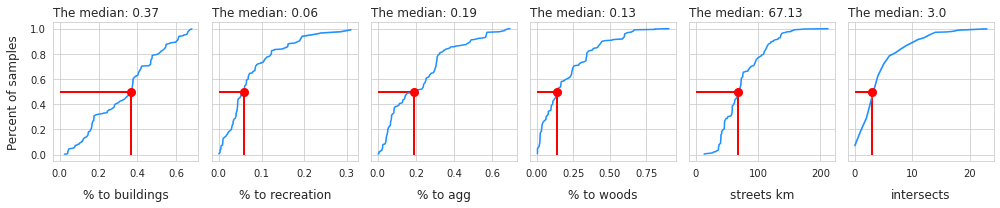

In [5]:
# explanatory variables that are being considered
luse_exp = ['% to buildings', '% to recreation', '% to agg', '% to woods', 'streets km', 'intersects']

# columns needed
use_these_cols = ['loc_date' ,
                  'date',
                  '% to buildings',
                  '% to trans',
                  '% to recreation',
                  '% to agg',
                  '% to woods',
                  'population',
                  'water_name_slug',
                  'streets km',
                  'intersects',
                  'groupname',
                  'code'
                 ]

# the land use data was unvailable for these municipalities
no_land_use = ['Walenstadt', 'Weesen', 'Glarus Nord', 'Quarten']

# slice the data by start and end date, remove the locations with no land use data
use_these_args = ((survey_data.date >= start_date)&(survey_data.date <= end_date)&(~survey_data.city.isin(no_land_use)))
survey_data = survey_data[use_these_args].copy()

# format the data and column names
survey_data.rename(columns={'str_rank':'street rank'}, inplace=True)
survey_data['streets km'] = survey_data.streets/1000
survey_data['date'] = pd.to_datetime(survey_data.date)

# work off a copy
new_som_data = survey_data.copy()

# the survey total for each survey indiffferent of object
dfdt = new_som_data.groupby(use_these_cols[:-2], as_index=False).agg({unit_label:'sum', 'quantity':'sum'})

# method to get the ranked correlation of pcs_m to each explanatory variable
def make_plot_with_spearmans(data, ax, n):
    sns.scatterplot(data=data, x=n, y=unit_label, ax=ax, color='black', s=30, edgecolor='white', alpha=0.6)
    corr, a_p = stats.spearmanr(data[n], data[unit_label])
    return ax, corr, a_p


sns.set_style("whitegrid")
fig, axs = plt.subplots(1,len(luse_exp), figsize=(14,3), sharey=True)

data = dfdt.copy()

for i, n in enumerate(luse_exp):
    ax=axs[i]
    
    # the ECDF of the land use variable
    the_data = ECDF(data[n].values)
    sns.lineplot(x=the_data.x, y= the_data.y, ax=ax, color='dodgerblue', label="% of surface area" )
    
    # get the median % of land use for each variable under consideration from the data
    the_median = data[n].median()
    
    # plot the median and drop horzontal and vertical lines
    ax.scatter([the_median], 0.5, color='red',s=50, linewidth=2, zorder=100, label="the median")
    ax.vlines(x=the_median, ymin=0, ymax=0.5, color='red', linewidth=2)
    ax.hlines(xmax=the_median, xmin=0, y=0.5, color='red', linewidth=2)
    
    #remove the legend from ax   
    ax.get_legend().remove()
    
    if i == 0:
        ax.set_ylabel("Percent of samples", **ck.xlab_k)
    else:
        pass
    
    # add the median value from all locations to the ax title
    ax.set_title(F"The median: {(round(the_median, 2))}",fontsize=12, loc='left')
    ax.set_xlabel(n, **ck.xlab_k)

plt.tight_layout()
plt.show()

**The land use** around the survey locations had a higher attribution to buildings as opposed to agriculture and woods. For example, half of all the surveys had at least  37\% of land use devoted to buildings as opposed to 19\% for agriculture or 13\% to woods. Land use devoted to recreation was at least 6% for half of all samples. 

**The length of the road network** within the buffer zone differentiates between locations that have other wise similar land use characteristics. The length of road per buffer ranges from 13km to 212km, 50% of the surveys had less than 67km of road network.

**The number of intersections** ranges from zero to 23, 50% of the surveys had 3 or fewer intersections within 1500m of the survey location. The size of the intersecting river or canal was not taken into consideration. Survey locations on rivers have zero intersections.

**The population** (not shown) is taken from statpop 2018 and represents the population of the municipality surrounding the survey location. The smallest population was 442 and the maximum was 415,367, 50% of the surveys come from municipalities with a population of at least 12,812.

### Choosing survey sites

The survey locations were chosen based on the following criteria:

1. Data from previous surveys (SLR, MCBP)
2. Year round safe access
3. Within 30 minutes walking distance from nearest public transport

**The survey locations represent the land use conditions accesible by public transport to $\approx$ 1.7 million people**. For more information see the document *Survey site selection and criteria*.

## Associating land use to survey results

### The data

There are 386 surveys from 143 locations. This includes rivers and lakes. The results from Walensee are excluded, the data was incomplete for that part of Switzerland. The mean was more than twice the median, reflecting the extreme values that are typical of beach-litter-surveys. {cite}`eubaselines` 

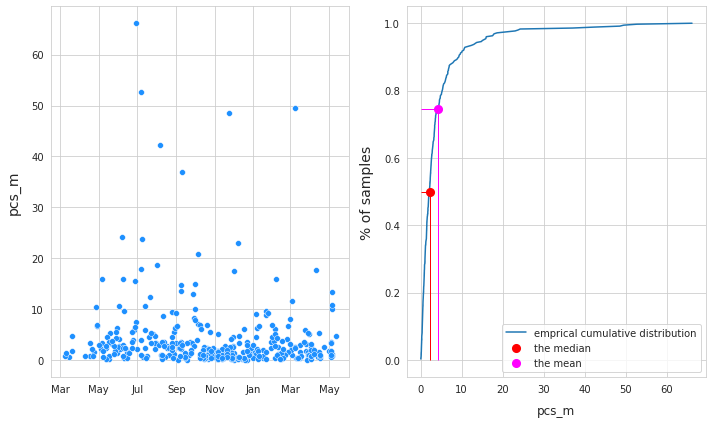

In [6]:
# set the date intervals for the chart
months = mdates.MonthLocator(interval=1)
months_fmt = mdates.DateFormatter('%b')
days = mdates.DayLocator(interval=7)

# set the grid for the chart
sns.set_style("whitegrid")

# chart the daily totals and the ECDF of all surveys under consideration
fig, ax = plt.subplots(1,2, figsize=(10,6), sharey=False)

axone=ax[0]
axtwo = ax[1]

axone.set_ylabel(unit_label, **ck.xlab_k14)
axone.xaxis.set_minor_locator(days)
axone.xaxis.set_major_formatter(months_fmt)
axone.set_xlabel(" ")

axtwo.set_ylabel("% of samples", **ck.xlab_k14)
axtwo.set_xlabel(unit_label, **ck.xlab_k)

# time series plot of the survey results
sns.scatterplot(data=dfdt, x='date', y=unit_label, color='dodgerblue', s=34, ec='white', ax=axone)

# ecdf of the survey results
this_ecdf = ECDF(dfdt.pcs_m.values)

# plot the cumulative disrtibution
sns.lineplot(x=this_ecdf.x,y=this_ecdf.y, ax=axtwo, label='emprical cumulative distribution')

# get the median and mean from the data
the_median = data[unit_label].median()
the_mean = data.pcs_m.mean()

# get the percentile ranking of the mean
p_mean = this_ecdf(the_mean)

# plot the median and drop horzontal and vertical lines
axtwo.scatter([the_median], 0.5, color='red',s=50, linewidth=2, zorder=100, label="the median")
axtwo.vlines(x=the_median, ymin=0, ymax=0.5, color='red', linewidth=1)
axtwo.hlines(xmax=the_median, xmin=0, y=0.5, color='red', linewidth=1)

# plot the mean and drop horzontal and vertical lines
axtwo.scatter([the_mean], p_mean, color='magenta',s=50, linewidth=2, zorder=100, label="the mean")
axtwo.vlines(x=the_mean, ymin=0, ymax=p_mean, color='magenta', linewidth=1)
axtwo.hlines(xmax=the_mean, xmin=0, y=p_mean, color='magenta', linewidth=1)

handle, labels = axtwo.get_legend_handles_labels()

plt.legend(handle,labels)

plt.tight_layout()

plt.show()

*Survey results and cumulative distribution all lakes and rivers (Walensee excluded).*

*Number of samples: 354, number of locations: 134, median:2.04 pcs/m, mean:4.11 pcs/m*

### Spearmans $\rho$ an example

Spearmans ranked correlation tests for a statistically significant monotonic relationship or association between two variables. The hypothesis is that there is no association between the land use profile and the survey results. {cite}`defspearmans` 

The test results relate the direction ($\rho$) of an association and whether or not that association is likely due to chance (p-value). For a test to be considered significant the p-value needs to be less than 0.05. {cite}`impspearmans`

1. The null hypothesis: there is no monotonic relationship between the two variables
2. The alternate hypothesis: there is a monotonic relationship and the sign (+/-) indicates the direction

It does not provide any information about the magnitude of the relationship. As an example consider the relationship of the survey results of cigarette ends with respect to the amount of land attributed to buildings or agriculture. {cite}`spearmansexplained`

*__Left:__ survey totals cigarette ends with respect to % of land to buildings. $\rho$= 0.39, p-value < .001*

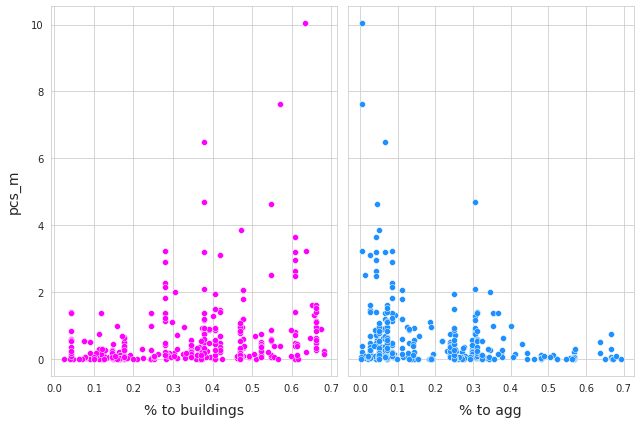

In [7]:
# data for the example
data = new_som_data[new_som_data.code == "G27"].groupby(["loc_date","% to buildings", "% to agg"], as_index=False)[unit_label].sum()

# run the test under the two conditions
sprmns_b = stats.spearmanr(data["% to buildings"], data[unit_label])
sprmns_a = stats.spearmanr(data["% to agg"], data[unit_label])

# plot the survey results with respect to the land use profile
fig, axs = plt.subplots(1,2, figsize=(9,6), sharey=True)

sns.scatterplot(data=data, x="% to buildings", y=unit_label, ax=axs[0], color='magenta')
sns.scatterplot(data=data, x="% to agg", y=unit_label, ax=axs[1], color='dodgerblue')

axs[0].set_xlabel("% to buildings", **ck.xlab_k14)
axs[1].set_xlabel("% to agg", **ck.xlab_k14)

axs[0].set_ylabel(unit_label, **ck.xlab_k14)

plt.tight_layout()
plt.show()

*__Right:__ survey totals cigarette ends with respect to % of land to aggriculture. $\rho$= -0.31, p-value < .001*

When the survey results for cigarette ends are considered with respect to the percent of land attributed to buildings or agriculture the the value of $\rho$ is opposite. The plot of the relationship (above) demonstrates the relationship of the survey values under the two conditions.

### Association of survey totals to land use

*Results of Spearmans ranked correlation test: survey totals with respect to land use profile*

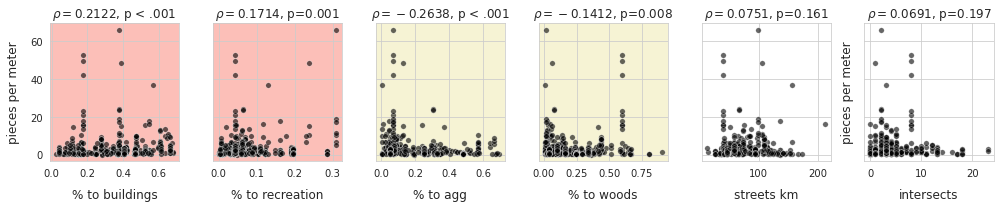

In [8]:
# correlation  of survey total to land use attributes:
fig, axs = plt.subplots(1,len(luse_exp), figsize=(14,3), sharey=True)

for i, n in enumerate(luse_exp):
    ax=axs[i]
    ax, corr, a_p = make_plot_with_spearmans(dfdt, ax, n)
    if i == 0:
        ax.set_ylabel('pieces per meter', **ck.xlab_k)
    ax.set_xlabel(n, **ck.xlab_k)
    if a_p <= .001:
        title_str = "p < .001"
    else:
        title_str = F"p={round(a_p, 3)}"
    
    ax.set_title(rF"$\rho={round(corr,4)}$, {title_str}")
    
    # find p    
    if a_p < 0.05:
        if corr > 0:
            ax.patch.set_facecolor('salmon')
            ax.patch.set_alpha(0.5)
        else:
            ax.patch.set_facecolor('palegoldenrod')
            ax.patch.set_alpha(0.5)

            plt.ylabel('pieces per meter', **ck.xlab_k)
plt.tight_layout()
plt.show()

In general a positive relationship can be assumed between survey results and percent of land to buildings or recreation, and a negative association with woods and agriculture. 

### Association of most common objects to land use

**The most common objects are** all objects that were either the ten most abundant by quantity or any object that was identified in at least 50% of all the surveys. In this way we are accounting for $\approx 68$% of all objects found and counted. These lists are not the same, not all objects that were found 50% of the time are found in large enough quantities to make the "top ten list".

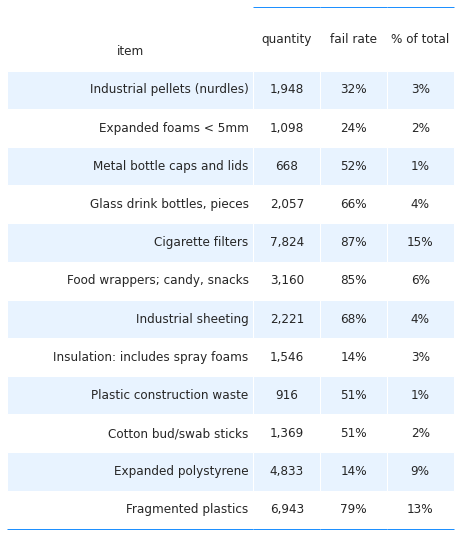

In [9]:
# the number of times an object was found at least once
code_fails = new_som_data.groupby('code').fail.sum()

# the ratio of found/not found
code_fail_rate = code_fails/new_som_data.loc_date.nunique()

# all codes with a fail rate > fail rate
better_than_50 = code_fail_rate[code_fail_rate > a_fail_rate]

# the number of times an object was found at least once
code_fails = new_som_data.groupby('code').fail.sum()

# the ratio of found/not found
code_fail_rate = code_fails/new_som_data.loc_date.nunique()

# all codes with a fail rate > fail rate
better_than_50 = code_fail_rate[code_fail_rate > a_fail_rate]

some_keys = {
    '% to buildings':'lu_build',
    '% to agg':'lu_agg',
    '% to woods':'lu_woods',
    '% to recreation':'lu_rec',
    '% to trans':'lu_trans',
    '% to meadow':'lu_m',
    'str_rank':'lu_trans',
}

code_totals = new_som_data.groupby('code').quantity.sum()

t_ten = code_totals.sort_values(ascending=False)[:10]
abundant_codes = list(t_ten.index)

for code in better_than_50.index:
    if code in t_ten.index:
        pass
    else:
        abundant_codes.append(code)

# get the survey date for the most common codes
m_common = new_som_data[new_som_data.code.isin(abundant_codes)].groupby('code', as_index=False).agg({'quantity':'sum', 'fail':'sum'})
m_common["% of total"] = ((m_common.quantity/new_som_data.quantity.sum())*100).astype('int')
m_common["fail rate"] = ((m_common.fail/new_som_data.loc_date.nunique())*100).astype('int')
m_common.set_index("code", inplace=True)

# format values for table
m_common['item'] = m_common.index.map(lambda x: code_description_map.loc[x])
m_common['% of total'] = m_common["% of total"].map(lambda x: F"{x}%")
m_common['quantity'] = m_common.quantity.map(lambda x: F'{x:,}')
m_common['fail rate'] = m_common['fail rate'].map(lambda x: F"{x}%")

# banded color for table
a_color = 'dodgerblue'

# final table data
cols_to_use = ['item','quantity', 'fail rate', '% of total']
all_survey_areas = m_common[cols_to_use].values

fig, axs = plt.subplots(figsize=(8,len(m_common)*.8))

ut.hide_spines_ticks_grids(axs)

the_first_table_data = axs.table(all_survey_areas,  colLabels=cols_to_use, colWidths=[.48, .13,.13,.13], bbox=[0, 0, 1, 1])

a_summary_table_one = sut.make_a_summary_table(the_first_table_data,m_common,cols_to_use, a_color)

plt.show()
plt.tight_layout()
plt.close()

#### Results Spearmans $\rho$

From the first figure a positive association can be assumed between the amount of trash found and the percent of land attributed to buildings and recreation. The inverse is true for the percent of land attributed to agriculture and woods, there is no statistical basis to assume a correlation with the length of streets or the number of river intersections and the total survey result.

The result of Spearman's rho on the most abundant objects gives context to the results in the preceding figure and changes and illustrates how the different objects tend to accumulate under different conditions.

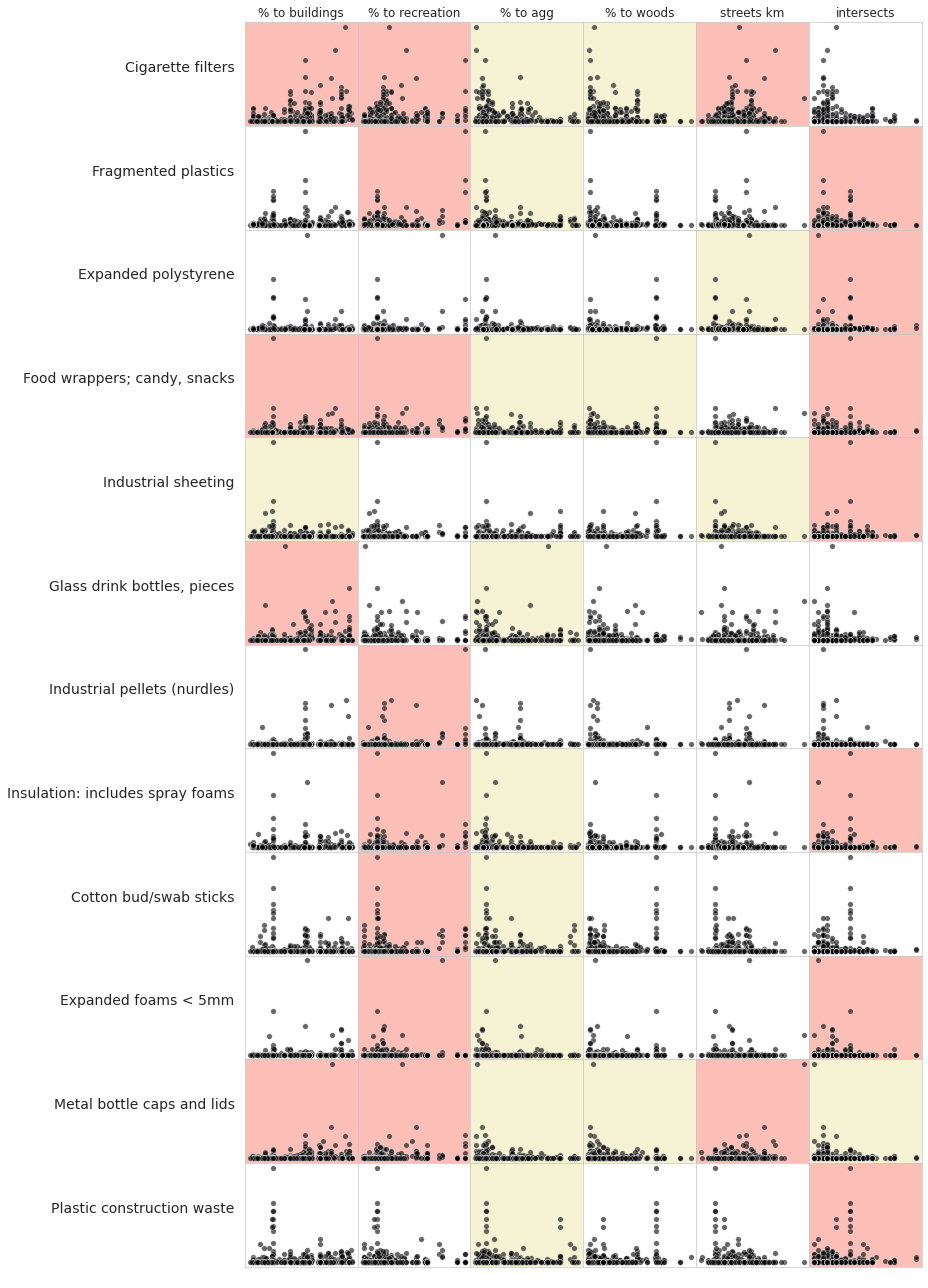

In [10]:
fig, axs = plt.subplots(len(abundant_codes),len(luse_exp), figsize=(len(luse_exp)+7,len(abundant_codes)+6), sharey='row')

for i,code in enumerate(abundant_codes):
    data = new_som_data[new_som_data.code == code]
    for j, n in enumerate(luse_exp):
        ax=axs[i, j]
        ax.grid(False)
        ax.tick_params(axis='both', which='both',bottom=False,top=False,labelbottom=False, labelleft=False, left=False)
       
        if i == 0:
            ax.set_title(F"{n}")
        else:
            pass
        
        if j == 0:
            ax.set_ylabel(F"{code_description_map[code]}", rotation=0, ha='right', **ck.xlab_k14)
            ax.set_xlabel(" ")
        else:
            ax.set_xlabel(" ")
            ax.set_ylabel(" ")
               
        _, corr, a_p = make_plot_with_spearmans(data, ax, n)
        
        if a_p < 0.05:
            if corr > 0:
                ax.patch.set_facecolor('salmon')
                ax.patch.set_alpha(0.5)
            else:
                ax.patch.set_facecolor('palegoldenrod')
                ax.patch.set_alpha(0.5)

plt.tick_params(labelsize=14, which='both', axis='both')
plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig(F"{project_directory}/test_one.jpg", dpi=300)
plt.show()

### Interpreting Spearmans $\rho$

A positive association means that the survey results had a tendency to increase as the percent value of the land use feature increased. This may be due to a covariance of attributes, either way **a positive association is a signal that the objects tend to accumulate under these conditions**.

A negative association means that the land use feature or attribute does not facilitate the accumulation of the object. This result is common for agricultural areas and woods on the national level. **A negative association is a signal that the locations are probably not a zone of accumulation for the object**.

No or few association means that the land use features had no effect on the accumulation of that object. The survey results of the most common objects with no or few associations fall into two characteristics: 

1. Ubiquitous: high fail rate, high pieces per meter. Found at consistent rates through out the survey area indifferent of land use
2. Transient: low fail rate, high quantity, high pieces per meter, few associations. Found occasionaly in large quantities at specific locations

## Discussion

Overall, surveys at locations with more buildings and more recreation sites were more likely to facilitate the accumulation of trash on the shoreline. When the most common objects are considered, only four of the twelve were found at higher rates in the presence of more buildings. All of those objects are likely related to food or tobacco consumption near the location. Suggesting that there are still gains to be made in prevention and attenuation efforts in areas of high traffic near the water.

However, six of the twelve objects have no positive association to land use attributed to buildings but were found in at least 50\% of all the surveys. These objects are generally associated with professional use or in the case of cotton swabs personal hygiene:

* plastic construction waste
* fragmented plastics
* industrial sheeting
* expanded polystyrene
* cotton bud/swabs
* insulation, includes spray foams

Furthermore, compared to products related to tobacco or food consumption these objects have fewer positive associations in general. Indicating that the appropriate land use feature is not currently accounted for and/or these objects are found at similar quantities indifferent of the land use features. Suggesting that these objects are ubiquitous in the environment.

Finally, two of the twelve most common objects were found in less than 50% of the surveys and have few positive associations:

* industrial pellets
* expanded foams < 5mm

These objects are found in large quantities sporadically at specific locations. They have been found in all survey areas and in all lakes. Industrial pellets have a very specific use and client base making it possible to find partners based on the density of the pellets found and the location of the nearest consumer or producer of pellets, see [Shared responsibility](transport).

### Application

Care must be taken to the number of samples used to determine an association using Spearmans $\rho$ and how much weight is placed on the results. The results for cigarettes are a good example. The graphs clearly show both negative and positive associations depending on the land use however, $\rho$ is less than 0.5/-0.5. This is far from a linear relationship and the magnitude remains undetermined.

Stakeholders may want to consider these results and how they apply to their specific situation. One conclusion that can be drawn from these results is that there is a method to identify zones of accumulation with reasonable certainty. These results allow stakeholders to base priorities on the challenges that are specific to their region or situation.

Spearmans correlation coefficient can easily be implemented once the final set of data has been determined. However, the coefficient value changes depending on the survey area or lake where the test is applied. This implies that understanding and interpreting these results is not just a national concern but also regional and municipal. 

__Why 1500 meters?__ For this study we were concerned with objects that had high values of $\rho$ for smaller radiuses that were appropriate for the scale of the provided data. Other distances were considered (2km, 2.5km, ... 5km and 10km), in general as the radius increases the amount of land attributed to buildings diminishes as well as the value of $\rho$. This topic was considered in more detail in an article that is currently being prepared for the peer-review process.

Association results should always be considered with all the other key indicators and expert judgment. Verification of an association can be done by sampling a specific zone for a defined period of time and comparing the results to the baseline values for the survey area. If the sampling zone has consistently higher survey results than the survey area then it is quite likely that the zone is a source or an area of accumulation.

To understand more on how survey results change and/or remain the same depending on land use conditions see [_Shared responsibility_](transport).

To understand how baseline values were calculated for this report see [_Beach litter baselines_](threshhold).

In [11]:
author = "roger@hammerdirt.ch"
my_message = "Love what you do. \u2764\ufe0f"
md(F"""
**This project was made possible by the Swiss federal office for the environment.**<br>

>{my_message}<br>

*{author}* pushed the run button on {today}.<br>
This document originates from https://github.com/hammerdirt-analyst/IQAASL-End-0f-Sampling-2021 all copyrights apply.<br>
""")


**This project was made possible by the Swiss federal office for the environment.**<br>

>Love what you do. ❤️<br>

*roger@hammerdirt.ch* pushed the run button on 2021-09-30.<br>
This document originates from https://github.com/hammerdirt-analyst/IQAASL-End-0f-Sampling-2021 all copyrights apply.<br>
